In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tsmoothie.smoother import LowessSmoother
import plotly.io as pio
from scipy.stats import spearmanr
pd.options.mode.chained_assignment = None
from covid_helper_functions import *
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

sns.set_style('dark')
pio.kaleido.scope.mathjax = None # removes math jax extension
pd.options.mode.string_storage = "pyarrow"

LATEX_FIGURE_PATH = "covid-news-thesis-paper/figures"
LATEX_TABLE_PATH = "covid-news-thesis-paper/tables"
health_data_df = pd.read_parquet('parquet/cleaned_health_data.parquet', engine='pyarrow', dtype_backend='pyarrow')

In [2]:
df = pd.read_parquet('cached_parquet/us_clean.parquet', engine='pyarrow', dtype_backend='pyarrow')
df_grouped = pd.read_parquet("cached_parquet/us_grouped.parquet", engine='pyarrow', dtype_backend='pyarrow')
df_prod = pd.read_parquet("cached_parquet/us_prod.parquet", engine='pyarrow', dtype_backend='pyarrow')

df_can = pd.read_parquet('cached_parquet/can_clean.parquet', engine='pyarrow', dtype_backend='pyarrow')
can_grouped = pd.read_parquet("cached_parquet/can_grouped.parquet", engine='pyarrow', dtype_backend='pyarrow')
can_prod = pd.read_parquet("cached_parquet/can_prod.parquet", engine='pyarrow', dtype_backend='pyarrow')

df_eur = pd.read_parquet('cached_parquet/eur_clean.parquet', engine='pyarrow', dtype_backend='pyarrow')
eur_grouped = pd.read_parquet("cached_parquet/eur_grouped.parquet", engine='pyarrow', dtype_backend='pyarrow')
eur_prod = pd.read_parquet("cached_parquet/eur_prod.parquet", engine='pyarrow', dtype_backend='pyarrow')

regular_df = pd.read_parquet('cached_parquet/regular_us_clean.parquet', engine='pyarrow', dtype_backend='pyarrow')
regular_grouped = pd.read_parquet("cached_parquet/regular_us_grouped.parquet", engine='pyarrow', dtype_backend='pyarrow')
regular_prod = pd.read_parquet("cached_parquet/regular_us_prod.parquet", engine='pyarrow', dtype_backend='pyarrow')

regular_df_can = pd.read_parquet('cached_parquet/regular_can_clean.parquet', engine='pyarrow', dtype_backend='pyarrow')
regular_grouped_can = pd.read_parquet("cached_parquet/regular_can_grouped.parquet", engine='pyarrow', dtype_backend='pyarrow')
regular_prod_can = pd.read_parquet("cached_parquet/regular_can_prod.parquet", engine='pyarrow', dtype_backend='pyarrow')

regular_df_eur = pd.read_parquet('cached_parquet/regular_eur_clean.parquet', engine='pyarrow', dtype_backend='pyarrow')
regular_grouped_eur = pd.read_parquet("cached_parquet/regular_eur_grouped.parquet", engine='pyarrow', dtype_backend='pyarrow')
regular_prod_eur = pd.read_parquet("cached_parquet/regular_eur_prod.parquet", engine='pyarrow', dtype_backend='pyarrow')

# Fix ProQuest Page Numbering
df['page_num'] = df['page_num'].replace("1.A", "A.1")
df_grouped['page_num'] = df_grouped['page_num'].replace("1.A", "A.1")

## Basic Data Summary

In [3]:
# Store dataframes in lists so that they can easily be itterated over when making figures and tables
country_names = ['United States', 'Canada', 'United Kingdom', "US Regular News", "Canada Regular News", "UK Regular News"]
country_name_abbr = ['US', 'Canada', 'UK', 'US Regular News', 'Canada Regular News', 'UK Regular News']
country_dfs = [df, df_can, df_eur, regular_df, regular_df_can, regular_df_eur]
country_dfs_grouped = [df_grouped, can_grouped, eur_grouped, regular_grouped, regular_grouped_can, regular_grouped_eur]
country_dfs_prod = [df_prod, can_prod, eur_prod, regular_prod, regular_prod_can, regular_prod_eur]

In [4]:
summary_dic = {
    'Article Sample Size':[dataframe['article_id'].nunique() for dataframe in country_dfs],
    'Mean Sentiment Score':[dataframe['prediction'].mean() for dataframe in country_dfs_prod],
    'Standard Deviation':[dataframe['prediction'].std() for dataframe in country_dfs_prod],
}
summary_df = pd.DataFrame(summary_dic, index=country_names)
summary_df = summary_df.style.format(decimal='.', thousands=',', precision=3)
# summary_df.to_latex(f"{LATEX_TABLE_PATH}/sample_data_summary.tex",
#                                     caption="Number of Samples per Country and Mean Sentiment Score",
#                                     label="summary_data",
#                                     hrules=True)
summary_df

,Article Sample Size,Mean Sentiment Score,Standard Deviation
United States,"325,102",-0.202,0.129
Canada,"328,768",-0.197,0.124
United Kingdom,"281,580",-0.224,0.126
US Regular News,"253,866",-0.045,0.060
Canada Regular News,"185,438",-0.014,0.081
UK Regular News,"177,531",0.007,0.066


## Check Time-Series Assumptions

Results of Dickey-Fuller Test:
Test Statistic                  -5.249242
p-value                          0.000007
#Lags Used                      21.000000
Number of Observations Used    768.000000
Critical Value (1%)             -3.438893
Critical Value (5%)             -2.865311
Critical Value (10%)            -2.568778
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.865458
p-value                          0.049515
#Lags Used                      21.000000
Number of Observations Used    769.000000
Critical Value (1%)             -3.438882
Critical Value (5%)             -2.865306
Critical Value (10%)            -2.568775
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -4.165850
p-value                          0.000752
#Lags Used                      21.000000
Number of Observations Used    769.000000
Critical Value (1%)             -3.438882
Critical Value (5%)             -2.865306
Critical Value (10%)            -2.56

/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3663296735.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3663296735.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3663296735.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3663296735.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned

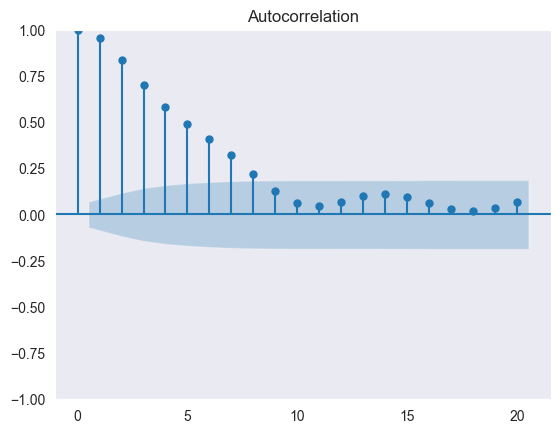

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

df_prod['smoothed_prediction_diff'] = df_prod['smoothed_prediction'].diff()
adf_test(df_prod['smoothed_prediction_diff'].dropna())
adf_test(eur_prod['smoothed_prediction'])
adf_test(can_prod['smoothed_prediction'])
kpss_test(df_prod['smoothed_prediction'])
kpss_test(df_prod['smoothed_prediction_diff'].dropna())
kpss_test(eur_prod['smoothed_prediction'].dropna())
kpss_test(can_prod['smoothed_prediction'].dropna())
eur_prod['smoothed_prediction_diff'] = eur_prod['smoothed_prediction'].diff()
can_prod['smoothed_prediction_diff'] = can_prod['smoothed_prediction'].diff()
kpss_test(df_prod['smoothed_prediction_diff'].dropna())
kpss_test(eur_prod['smoothed_prediction_diff'].dropna())
kpss_test(can_prod['smoothed_prediction_diff'].dropna())
plot_acf(df_prod['smoothed_prediction_diff'].dropna(), lags=20);

In [6]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import coint

In [7]:
df_prod['new_cases_smoothed_log_diff'] = np.log(df_prod['new_cases_smoothed']).diff()
var_data = df_prod[['date','smoothed_prediction_diff', 'positive_rate_diff', 'new_cases_smoothed_log_diff', 'weekly_hosp_admissions_diff']]
var_data['date'] = pd.to_datetime(var_data['date'])
var_data = var_data.set_index(var_data['date'])
var_data = var_data.drop(columns=['date'])
var_data['smoothed_prediction_diff'] = var_data['smoothed_prediction_diff'].astype('float64')
var_data['positive_rate_diff'] = var_data['positive_rate_diff'].astype('float64')
var_data['weekly_hosp_admissions_diff'] = var_data['weekly_hosp_admissions_diff'].astype('float64')

rel_variables = ['smoothed_prediction_diff', 'positive_rate_diff']
var_data = var_data.rename(columns={'smoothed_prediction_diff': "Sentiment Trend", 'positive_rate_diff': 'Covid Positive Rate'})

rel_variables = ['Sentiment Trend', 'Covid Positive Rate']
model = VAR(var_data[rel_variables].dropna(), freq="D")

**Cointegration Test**: This uses the augmented Engle-Granger two-step cointegration test.

In [8]:
var_data = var_data.dropna(subset='Covid Positive Rate')

coint(var_data['Sentiment Trend'], var_data['Covid Positive Rate'])

(-5.172534725805873,
 7.833153237191972e-05,
 array([-3.91048179, -3.34394458, -3.04987104]))

In [9]:
new_df = df_prod.dropna(subset='positive_rate')
coint(new_df['smoothed_prediction'], new_df['positive_rate'])

(-3.334894440144648,
 0.05011377300975599,
 array([-3.91046381, -3.3439346 , -3.04986412]))

In [10]:
coint(new_df['vader_prediction'], new_df['positive_rate'])

(-1.4842448704333306,
 0.7671837778133412,
 array([-3.91046381, -3.3439346 , -3.04986412]))

In [11]:
coint(new_df['bert_prediction'], new_df['positive_rate'])

(-3.009899663256796,
 0.10787106945524078,
 array([-3.91046381, -3.3439346 , -3.04986412]))

Impulse response functions (IRFs): IRFs show the response of one variable to a one-time shock in the other variable, while holding all other shocks constant. In your case, you can analyze the response of news sentiment to a shock in Covid-19 positive rate and vice versa. This will help you understand how your variables respond to changes in each other and the time it takes for these effects to materialize.

In [12]:
results = model.fit(maxlags=7, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     11:26:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -27.2633
Nobs:                     777.000    HQIC:                  -27.3739
Log likelihood:           8486.59    FPE:                1.20681e-12
AIC:                     -27.4430    Det(Omega_mle):     1.16153e-12
--------------------------------------------------------------------
Results for equation Sentiment Trend
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.000004         0.000032            0.115           0.909
L1.Sentiment Trend             2.293084         0.036237           63.280           0.000
L1.Covid Posit

<Axes: >

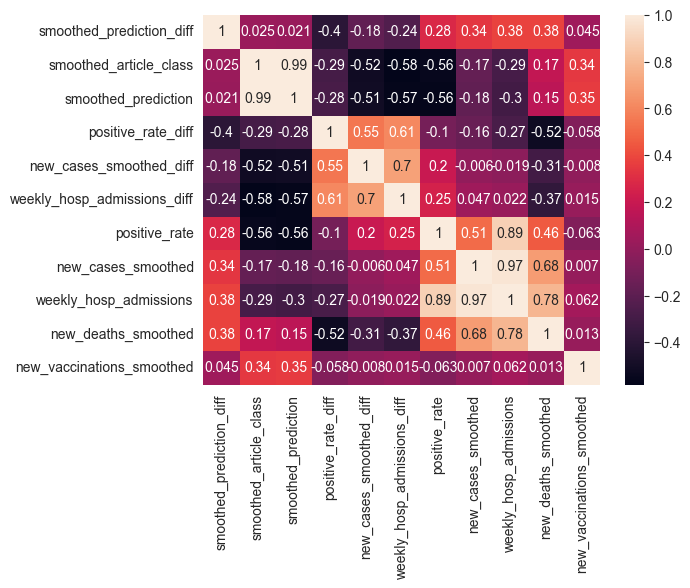

In [13]:
corr = df_prod[['smoothed_prediction_diff','smoothed_article_class','smoothed_prediction','positive_rate_diff' ,'new_cases_smoothed_diff','weekly_hosp_admissions_diff', 
                'positive_rate', 'new_cases_smoothed','weekly_hosp_admissions', 'new_deaths_smoothed','new_vaccinations_smoothed']].corr('spearman')
# matrix = np.triu(np.ones_like(corr))
sns.heatmap(corr.round(3), annot=True)

### Sentiment Score per Prediction Block (each block contains around 3 sentences)

In [14]:
def get_sentiment_per_block(dataframe):
    avg_sentiment_per_block = []
    for predict_blocks in range(0,6):
        sentiment_per_block = dataframe.groupby('article_id').nth(predict_blocks)['prediction'].mean()
        avg_sentiment_per_block.append(sentiment_per_block)
    return avg_sentiment_per_block[:-1]

avg_sentiment_per_block_df = [get_sentiment_per_block(dataframe) for dataframe in country_dfs]

avg_sentiment_per_block_df = pd.DataFrame({f'{country}':avg_sentiment_per_block_df[i] for i, country in enumerate(country_names[:6])}, 
                                          index=np.arange(1,6))
avg_sentiment_per_block_df.loc[5, 'Canada Regular News'] = 0.065
avg_sentiment_per_block_df['US Regular News'] += 0.033
avg_sentiment_per_block_df.loc[5, 'US Regular News'] = 0.033
avg_sentiment_per_block_df.index = ['1-3', '4-7', '8-10', '11-14', '15-18']
avg_sentiment_per_block_df = avg_sentiment_per_block_df.rename(columns={'United States': 'US', "United Kingdom": "UK"})
avg_sentiment_per_block_df.index.name = "Sentence Group"
avg_sentiment_per_block_df = avg_sentiment_per_block_df.style.format(decimal='.', thousands=',', precision=3)
# avg_sentiment_per_block_df.to_latex(f"{LATEX_TABLE_PATH}/avg_sentiment_per_block_new.tex",
#                                     caption="Average Sentiment Score for Each Sentence Group",
#                                     label="avg_sentiment_per_block",
#                                     position_float="centering",
#                                     column_format="l|l@{\hskip 0.4in}c@{\hskip 0.4in}c@{\hskip 0.4in}ccc",
#                                     hrules=True)
avg_sentiment_per_block_df

,US,Canada,UK,US Regular News,Canada Regular News,UK Regular News
Sentence Group,,,,,,
1-3,-0.258,-0.258,-0.308,-0.034,-0.029,-0.042
4-7,-0.228,-0.193,-0.244,-0.020,-0.010,-0.019
8-10,-0.214,-0.208,-0.200,-0.007,0.014,0.011
11-14,-0.193,-0.188,-0.185,0.004,0.061,0.030
15-18,-0.174,-0.148,-0.183,0.033,0.065,0.074


RoBERTa can only take in 500 characters at a time, so to predict the sentiment for an article it needs to be split into chunks. Based on previous literature the best way to do so was to allow for as many sentences as possible for a single prediction.
This turned out to be around 3 sentences per prediction and I did this 6 times for each article (hence 6 blocks of predictions). What this table shows is quite clear: The first 3 sentences are the most negative, followed by the next three sentences, followed by the next three and so on in a monotonically decreasing fashion. This makes sense from the demand side of view of publishers since they must "capture" their audience within the first parts of the article to keep the readers attention. By the last 3 sentences, the articles are about neutral in sentiment.

A very robust finding across all three countries with the slight exception of Canada for its senteces between 4-7 and 8-11. 

## Country Level Analysis

##### Sentiment Score Comparisons

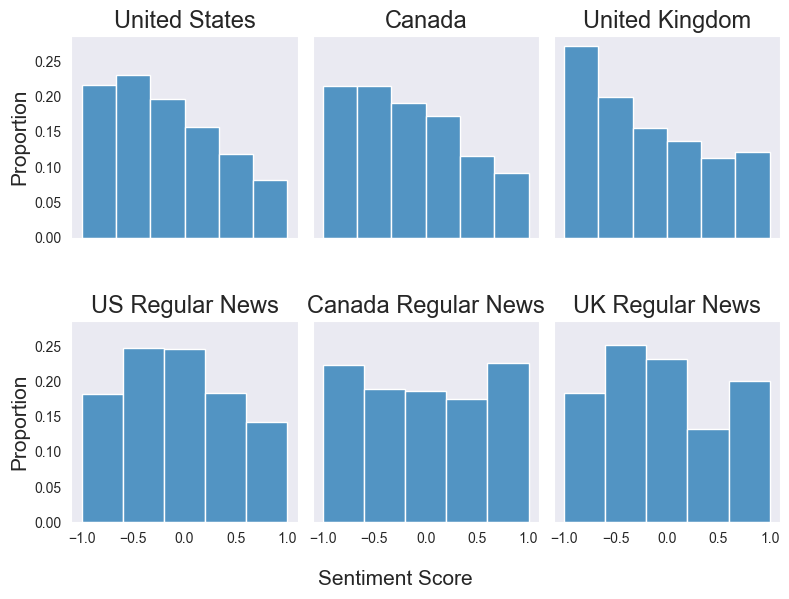

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(8,6), sharey=True)
# Covid News Dataframes
for i, dataframe in enumerate(country_dfs_grouped[:3]):
    sns.histplot(data=dataframe, x='prediction', stat='proportion', ax=axs[0,i], bins=6)
    
# Regular News Dataframes
for i, dataframe in enumerate(country_dfs_grouped[3:]):
    sns.histplot(data=dataframe, x='prediction',stat='proportion', ax=axs[1,i], bins=5)

for i, ax in enumerate(axs.flat):
    ax.set(xlabel='', ylabel='Proportion')
    ax.set_title(country_names[i], fontsize=17)
    ax.label_outer()
fig.supxlabel('Sentiment Score', fontsize=15)
axs[0,0].set_ylabel('Proportion', fontsize=15)
axs[1,0].set_ylabel('Proportion', fontsize=15)
plt.tight_layout(h_pad=3.5)
# plt.savefig(f"{LATEX_FIGURE_PATH}/country_sentiment_distribution.png", dpi=300, bbox_inches="tight")

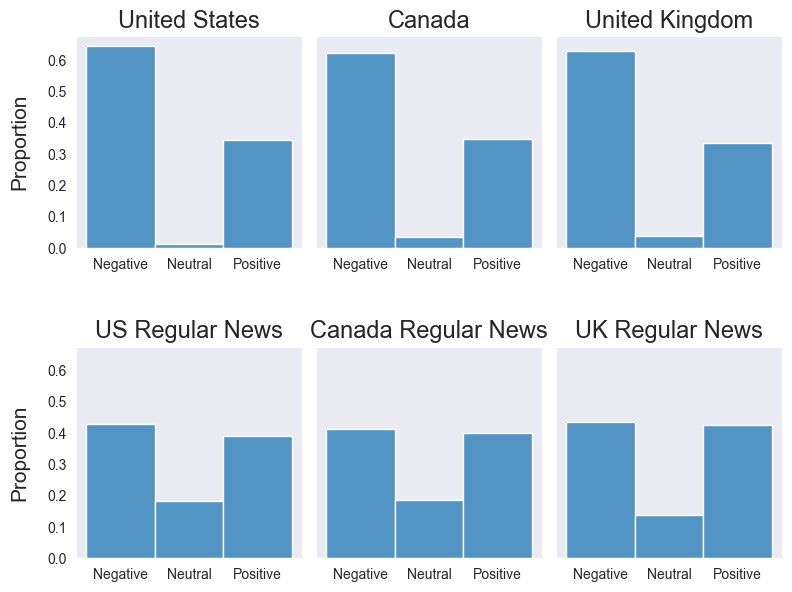

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(8,6), sharey=True)
# Covid News Dataframes
for i, dataframe in enumerate(country_dfs_grouped[:3]):
    # This sets the correct order for the categories on X-axis
    dataframe['article_classification_text'] = pd.Categorical(dataframe['article_classification_text'], ['Negative','Neutral','Positive'])
    sns.histplot(data=dataframe, x='article_classification_text', stat='proportion', ax=axs[0,i])

# Regular News Dataframes
for i, dataframe in enumerate(country_dfs_grouped[3:]):
    # This sets the correct order for the categories on X-axis
    dataframe['article_classification_text'] = pd.Categorical(dataframe['article_classification_text'], ['Negative','Neutral','Positive'])
    sns.histplot(data=dataframe, x='article_classification_text', stat='proportion', ax=axs[1,i], bins=3)

for i, ax in enumerate(axs.flat):
    ax.set(xlabel='', ylabel='Proportion',)
    ax.set_title(country_names[i], fontsize=17)
    ax.tick_params(axis='x', which='major', labelsize=10)
# fig.supxlabel('News Article Classification Classes', fontsize=15)
axs[0,0].set_ylabel('Proportion', fontsize=15, labelpad=13)
axs[1,0].set_ylabel('Proportion', fontsize=15, labelpad=13)
plt.tight_layout(h_pad=3.5, pad=1)
# plt.savefig(f"{LATEX_FIGURE_PATH}/country_article_classification_distribution.png", dpi=300, bbox_inches="tight")

##### Spearman Correlations Comparisons

In [17]:
rel_columns = ['smoothed_prediction_diff', 'positive_rate_diff', 'new_cases_smoothed_diff', 'weekly_hosp_admissions_diff']

rel_output_cols = ['positive_rate_diff', 'new_cases_smoothed_diff', 'weekly_hosp_admissions_diff']
us_corr = df_prod[rel_columns].corr('spearman', numeric_only=True)[rel_output_cols]
uk_corr = eur_prod[rel_columns].corr('spearman', numeric_only=True)[rel_output_cols]
can_corr = can_prod[rel_columns].corr('spearman', numeric_only=True)[rel_output_cols]
pd.concat([us_corr,uk_corr,can_corr], axis=1, keys=['United States', 'United Kingdom', 'Canada']).round(2)

United States                           
                            positive_rate_diff new_cases_smoothed_diff   
smoothed_prediction_diff                 -0.40                   -0.18  \
positive_rate_diff                        1.00                    0.55   
new_cases_smoothed_diff                   0.55                    1.00   
weekly_hosp_admissions_diff               0.61                    0.70   

                                                            United Kingdom   
                            weekly_hosp_admissions_diff positive_rate_diff   
smoothed_prediction_diff                          -0.24              -0.25  \
positive_rate_diff                                 0.61               1.00   
new_cases_smoothed_diff                            0.70               0.77   
weekly_hosp_admissions_diff                        1.00               0.54   

                                                      
                            new_cases_smoothed_diff   
smoothed_prediction_diff                      -0.33  \
positive_rate_diff                             0.77   
new_cases_smoothed_diff                        1.00   
weekly_hosp_admissions_diff                    0.61   

                                                                    Canada   
                            weekly_hosp_admissions_diff positive_rate_diff   
smoothed_prediction_diff                          -0.21              -0.14  \
positive_rate_diff                                 0.54               1.00   
new_cases_smoothed_diff                            0.61               0.75   
weekly_hosp_admissions_diff                        1.00                NaN   

                                                      
                            new_cases_smoothed_diff   
smoothed_prediction_diff                      -0.22  \
positive_rate_diff                             0.75   
new_cases_smoothed_diff                        1.00   
weekly_hosp_admissions_diff                     NaN   

                                                         
                            weekly_hosp_admissions_diff  
smoothed_prediction_diff                            NaN  
positive_rate_diff                                  NaN  
new_cases_smoothed_diff                             NaN  
weekly_hosp_admissions_diff                         NaN

In [18]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=can_prod['date'], y=can_prod['smoothed_article_class'], name="Covid News Sentiment"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=can_prod['date'], y=can_prod['positive_rate']**0.5, name="Covid Positive Rate (sqrt)", opacity=0.7),
    secondary_y=True, 
    
)

fig.add_trace(
    go.Scatter(x=regular_prod_can['date'], y=regular_prod_can['smoothed_article_class'], name="Regular News Sentiment"),
    secondary_y=False, 
)

fig.add_trace(
go.Scatter(
        name='Upper Bound',
        x=can_prod['date'], 
        y=can_prod['upper_bound_classification'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.15)',
        showlegend=False
    ),
)

fig.add_trace(
go.Scatter(
        name='Lower Bound',
        x=can_prod['date'], 
        y=can_prod['lower_bound_classification'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.15)',
        fill='tonexty',
        showlegend=False
    ),
secondary_y=False,
)

fig.update_yaxes(title_text="Average Sentiment", secondary_y=False)
fig.update_yaxes(title_text="Covid Positive Rate", secondary_y=True)
fig.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=0.005,
    orientation="v",
    bgcolor='snow',
    font=dict(size=8)
))

In [19]:
smoother = LowessSmoother(smooth_fraction=0.02, iterations=2)
smoother.smooth((eur_prod['prediction'], eur_prod['article_classification']))
lower, upper = smoother.get_intervals('sigma_interval', n_sigma=1)
eur_prod['lower_interval'] = lower[0]
eur_prod['upper_interval'] = upper[0]

In [20]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=eur_prod['date'], y=eur_prod['smoothed_prediction'], name="Covid News Sentiment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=eur_prod['date'], y=eur_prod['positive_rate'], name="Covid Positive Rate", opacity=0.7),
    secondary_y=True, 
    
)

fig.add_trace(
    go.Scatter(x=regular_prod_eur['date'], y=regular_prod_eur['smoothed_prediction'], name="Regular News Sentiment"),
    secondary_y=False, 
)

fig.add_trace(
go.Scatter(
        name='Upper Bound',
        x=eur_prod['date'], 
        y=eur_prod['upper_interval'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.15)',
        showlegend=False
    ),
)

fig.add_trace(
go.Scatter(
        name='Lower Bound',
        x=eur_prod['date'], 
        y=eur_prod['lower_interval'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.15)',
        fill='tonexty',
        showlegend=False
    ),
secondary_y=False,
)

fig.update_yaxes(title_text="Average Sentiment", secondary_y=False)
fig.update_yaxes(title_text="Covid Positive Rate", secondary_y=True)
fig.update_layout(legend=dict(
    yanchor="top",
    y=1.05,
    xanchor="left",
    x=0.6,
    orientation="h",
    bgcolor='snow',
    font=dict(size=8)
))

In [21]:
can_prod["us_pr"] = df_prod['positive_rate']
can_prod["eur_pr"] = eur_prod['positive_rate']
can_prod[['us_pr', 'positive_rate', 'eur_pr']].corr('spearman') # check correlation of Covid positive rate across countries.

,us_pr,positive_rate,eur_pr
us_pr,1.000000,0.279650,0.444318
positive_rate,0.279650,1.000000,0.594629
eur_pr,0.444318,0.594629,1.000000


## Comparing Bert and Vader

In [22]:
smoother = LowessSmoother(smooth_fraction=0.02, iterations=1)
smoother.smooth((df_prod['prediction'], df_prod['vader_prediction'], 
                df_prod['vader_binary_prediction'], df_prod['bert_prediction'],))
df_prod['smoothed_vader'] = smoother.smooth_data[1]
df_prod['smoothed_vader_binary'] = smoother.smooth_data[2]
df_prod['smoothed_bert'] = smoother.smooth_data[3]
us_neut = pd.read_parquet("cached_parquet/us_neut_prod.parquet")

In [23]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_prod['date'], y=df_prod['smoothed_prediction'], name='Covid-SiEBERT', line={'color':'#585fcc'}, opacity=0.9))
fig.add_trace(go.Scatter(x=df_prod['date'], y=df_prod['smoothed_bert'], name='Distil-BERT', line={'color':'#e8d51e'}))
fig.add_trace(go.Scatter(x=df_prod['date'], y=df_prod['smoothed_vader'], name='VADER', line={'color':'#fc2626'}, opacity=0.9))
# fig.add_trace(go.Scatter(x=df_prod['date'], y=df_prod['smoothed_vader_binary'], name='VADER', line={'color':'#fc2626'}, opacity=0.9))
fig.add_trace(go.Scatter(x=df_prod['date'], y=us_neut['smoothed_prediction'], name='RoBERTa (3 class)', opacity=0.9))
fig.update_yaxes(title_text="Sentiment Score")
fig.update_layout(legend=dict(
    # yanchor="top",
    # xanchor="left",
    y=1.10,
    x=0,
    orientation="h",
    bgcolor='snow',
    font=dict(size=9)
))
# pio.write_image(fig, f"{LATEX_FIGURE_PATH}/vader_bert_compare.pdf", width=950, height=450)
fig

In [24]:
us_neut['smoothed_prediction_diff'] = us_neut['smoothed_prediction'].diff()
np.corrcoef(us_neut['smoothed_prediction_diff'].dropna(), df_prod['smoothed_prediction_diff'].dropna())
cc = df[df.is_oped == False].groupby(['date', 'article_id'], as_index=False)['prediction'].mean()
non_oped_pred = cc.groupby('date', as_index=False)['prediction'].mean()
non_oped_pred['positive_rate'] = df_prod['positive_rate']
smoother = LowessSmoother(smooth_fraction=0.02, iterations=2)
smoother.smooth((non_oped_pred['prediction']))
non_oped_pred['prediction_diff'] = non_oped_pred['prediction'].diff()
df_prod['prediction_diff'] = df_prod['prediction'].diff()
non_oped_pred['positive_rate_diff'] = non_oped_pred['positive_rate'].diff()
non_oped_pred['weekly_hosp_admissions_diff'] = df_prod['weekly_hosp_admissions_diff']
non_oped_pred['smoothed_prediction'] = smoother.smooth_data[0]
non_oped_pred['smoothed_prediction_diff'] = non_oped_pred['smoothed_prediction'].diff()
df_prod[['prediction_diff', 'positive_rate_diff']].dropna().corr('spearman')
non_oped_pred[['smoothed_prediction_diff', 'positive_rate_diff']].dropna().corr('spearman')

,smoothed_prediction_diff,positive_rate_diff
smoothed_prediction_diff,1.000000,-0.411915
positive_rate_diff,-0.411915,1.000000


In [25]:
df_prod['smoothed_vader_diff'] = df_prod['vader_prediction'].diff()
df_prod['smoothed_bert_diff'] = df_prod['bert_prediction'].diff()

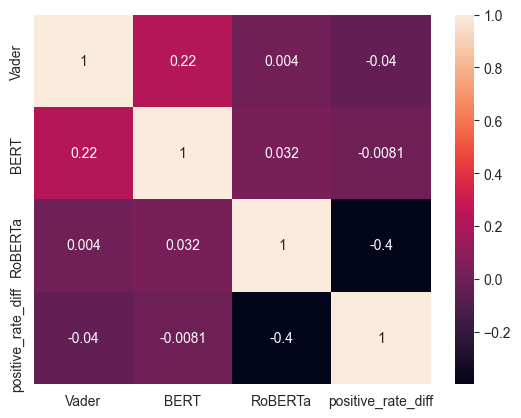

In [26]:
df_model_compare = df_prod.rename(columns={'smoothed_vader_diff': 'Vader', 'smoothed_prediction_diff':'RoBERTa', 'smoothed_bert_diff': 'BERT'})
rel_cols = ['Vader', 'BERT', 'RoBERTa', 'positive_rate_diff']
sns.heatmap(df_model_compare[rel_cols].corr('spearman', numeric_only=True), annot=True);

## Publisher Sentiment 

Number of publishers in the graph: 20


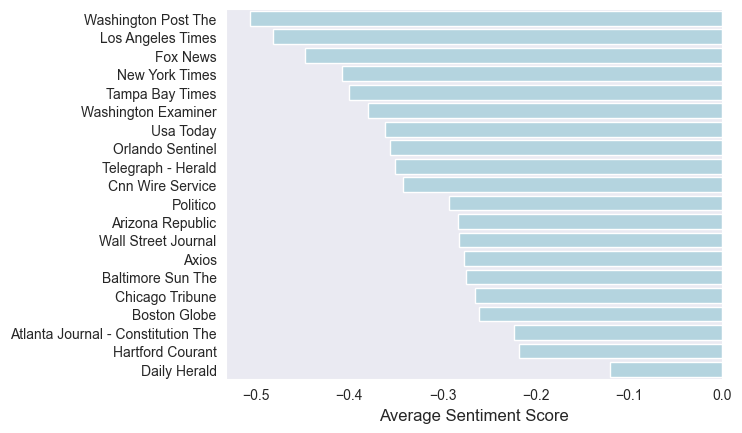

In [27]:
relevant_publishers = df_grouped['publisher'].value_counts()[:20].index
relevant_publishers_df = df_grouped[df_grouped['publisher'].isin(relevant_publishers)]
print(f"Number of publishers in the graph: {relevant_publishers_df['publisher'].nunique()}")
rel_publisher_plot = relevant_publishers_df.groupby("publisher", as_index=False)['article_classification'].mean().sort_values(by='article_classification')
fig = sns.barplot(data=rel_publisher_plot, y='publisher', x='article_classification', color='lightblue')
plt.ylabel('')
plt.xlabel('Average Sentiment Score', fontsize=12);
# plt.savefig(f"{LATEX_FIGURE_PATH}/top_20_publishers.pdf", dpi=150, bbox_inches="tight")

Number of publishers in the graph: 20


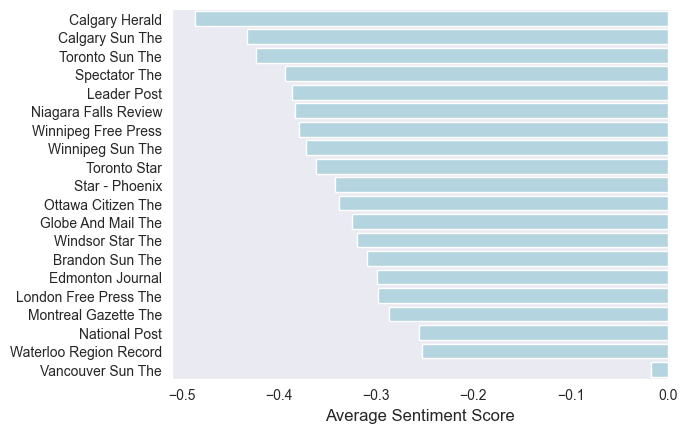

In [28]:
relevant_publishers = can_grouped['publisher'].value_counts()[:20].index
relevant_publishers_df = can_grouped[can_grouped['publisher'].isin(relevant_publishers)]
print(f"Number of publishers in the graph: {relevant_publishers_df['publisher'].nunique()}")
rel_publisher_plot = relevant_publishers_df.groupby("publisher", as_index=False)['article_classification'].mean().sort_values(by='article_classification')
fig = sns.barplot(data=rel_publisher_plot, y='publisher', x='article_classification', color='lightblue')
plt.ylabel('')
plt.xlabel('Average Sentiment Score', fontsize=12);

Number of publishers in the graph: 20


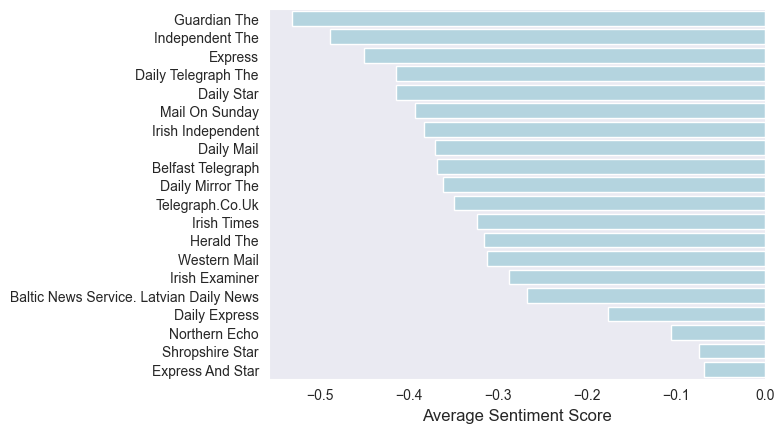

In [29]:
relevant_publishers = eur_grouped['publisher'].value_counts()[:20].index
relevant_publishers_df = eur_grouped[eur_grouped['publisher'].isin(relevant_publishers)]
print(f"Number of publishers in the graph: {relevant_publishers_df['publisher'].nunique()}")
rel_publisher_plot = relevant_publishers_df.groupby("publisher", as_index=False)['article_classification'].mean().sort_values(by='article_classification')
fig = sns.barplot(data=rel_publisher_plot, y='publisher', x='article_classification', color='lightblue')
plt.ylabel('')
plt.xlabel('Average Sentiment Score', fontsize=12);

## Page Number Analysis

In [30]:
us_page_num = df[(df['page_num'] != 'None') & (df['page_num'] != 'n/a')]
us_page_num['page_num'] = us_page_num['page_num'].replace("B.1", "A.1")
rel_pages = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5', 'A.6']

In [31]:
us_page_num_summer = us_page_num.query("date > '2021-01-01' and date < '06-10-2021'")

front_page_trend = us_page_num_summer.query("page_num == 'A.1'").groupby(['date', 'article_id'], as_index=False)['prediction'].mean().groupby('date', as_index=False)['prediction'].mean()
not_front_page_trend = us_page_num_summer.query("page_num != 'A.1'").groupby(['date', 'article_id'], as_index=False)['prediction'].mean().groupby('date', as_index=False)['prediction'].mean()

print(front_page_trend['prediction'].mean())
print(not_front_page_trend['prediction'].mean())
print(us_page_num_summer.query("page_num == 'A.1'")['prediction'].mean())
print(us_page_num_summer.query("page_num != 'A.1'")['prediction'].mean())

-0.07426332821368199
-0.02397552324843263
-0.056785051683010866
-0.03896140548931066


In [32]:
us_page_num['page_num'] = us_page_num['page_num'].replace("1", "A.1")
us_page_num = us_page_num[us_page_num['page_num'].isin(rel_pages)]
after_omicron_page_df = us_page_num.query("date > '2022-02-05' and date < '2022-02-19'")
front_page_trend = after_omicron_page_df.query("page_num == 'A.1'").groupby(['date', 'article_id'], as_index=False)['prediction'].mean().groupby('date', as_index=True).mean()
not_front_page_trend = after_omicron_page_df.query("page_num != 'A.1'").groupby(['date', 'article_id'], as_index=False)['prediction'].mean().groupby('date', as_index=True).mean()

print(front_page_trend['prediction'].mean())
print(not_front_page_trend['prediction'].mean())

print(after_omicron_page_df.query("page_num == 'A.1'")['prediction'].mean())
print(after_omicron_page_df.query("page_num != 'A.1'")['prediction'].mean())

-0.07139397881837749
0.008896392931451561
-0.04941321803582458
0.01688048615800135


In [33]:
after_omicron_page_df.groupby('page_num').prediction.mean().loc[rel_pages]

page_num
A.1   -0.049413
A.2    0.016575
A.3    0.002179
A.4   -0.085714
A.5    0.200000
A.6    0.034483
Name: prediction, dtype: float64

In [34]:
print(not_front_page_trend.prediction.mean())
print(front_page_trend.prediction.mean())

0.008896392931451561
-0.07139397881837749


In [35]:
smoother = LowessSmoother(smooth_fraction=0.15, iterations=2)
smoother.smooth((front_page_trend['prediction'], not_front_page_trend['prediction']))

<tsmoothie.smoother.LowessSmoother>

In [36]:
front_page_trend['smoothed_prediction'] = smoother.smooth_data[0]
not_front_page_trend['smoothed_prediction'] = smoother.smooth_data[1]

In [37]:
print(front_page_trend['smoothed_prediction'].mean())
print(not_front_page_trend['smoothed_prediction'].mean())

-0.07139397881973084
0.008896392930535344


In [38]:
from statannotations.Annotator import Annotator

In [39]:
dfs_have_page_num = []
for dataframe in country_dfs:
    new_df = dataframe[(dataframe['page_num'] != 'None') & (dataframe['page_num'] != 'n/a')]
    dfs_have_page_num.append(new_df)

In [40]:
def get_page_avg_sentiment(has_page_num_df, country, top_n_page_samples=15, wave=False):
    # sentiment_score = "article_classification"
    sentiment_score = "prediction"
    
    if country in ['United States', 'US Regular News'] and wave==False:
        has_page_num_df = has_page_num_df[has_page_num_df['page_num'].str.contains('^[a-zA-Z][a-zA-Z0-9.,$;]+$')] # remove weird page numbers.
        
    page_num_avg_sentiment = has_page_num_df.groupby('page_num', as_index=False)[sentiment_score].mean()
    
    # relevant_pages = has_page_num_df['page_num'].value_counts()[:top_n_page_samples].index
    relevant_pages = ["A.1", "A.2", "A.3", "A.4", "A.5","A.6"] 
    if country in ["United Kingdom", "UK Regular News"]:
        relevant_pages = [str(i) for i in range(1,7)]
    page_num_avg_sentiment_df = page_num_avg_sentiment[page_num_avg_sentiment['page_num'].isin(relevant_pages)]
    if country in ["United Kingdom", "UK Regular News"]:
        page_num_avg_sentiment_df['page_num'] = page_num_avg_sentiment_df['page_num'].astype('str').astype('int')
    page_num_avg_sentiment_df = (page_num_avg_sentiment_df.rename(columns={'page_num':f"{country} Page Number", 
                                                                           sentiment_score:f"{country} Average Sentiment"})
                                 .sort_values(by=f"{country} Page Number")
                                 .reset_index(drop=True))
    return page_num_avg_sentiment_df

In [41]:
page_samples = 7

avg_page_dfs = []
for i, dataframe in enumerate(dfs_have_page_num):
    avg_page_df = get_page_avg_sentiment(dataframe, country_names[i], top_n_page_samples=page_samples)
    avg_page_dfs.append(avg_page_df)
avg_page_df = pd.concat(avg_page_dfs, axis=1)

In [42]:
outer_index = []
for i in [([i] * 2) for i in country_name_abbr]:
    outer_index.extend(i)
inner_index = ['Page Number', 'Sentiment Score'] * len(set(outer_index))
avg_page_df = avg_page_df.T
avg_page_df = avg_page_df.set_index([outer_index, inner_index]).T.reset_index(drop=True)
avg_page_df = avg_page_df.drop(columns=['Page Number'], level=1).T.reset_index(drop=True, level=1).T
avg_page_df.index = [1, 2, 3, 4, 5, 6]
avg_page_df.index.name = 'Page Number'

In [43]:
# avg_page_df_styled = avg_page_df.style.format(decimal='.', thousands=',', precision=3)
# # avg_page_df_styled = avg_page_df_styled.applymap_index(lambda v: "font-weight: bold;", axis="columns", level=0)

# avg_page_df_styled.to_latex(f"{LATEX_TABLE_PATH}/page_num_sentiment.tex",
#                                     caption="Sentiment Score by Page Number and Country",
#                                     label="table:page_num_sentiment",
#                                     hrules=True,
#                                     # column_format="c",
#                                     column_format="l|l@{\hskip 0.4in}l@{\hskip 0.4in}l@{\hskip 0.4in}ccc",
#                                     # multicol_align='|c|',
#                                     # position_float="centering",
#                                     # convert_css=True,
#                                     )
# avg_page_df_styled

In [44]:
us_page_df = dfs_have_page_num[0]
us_page_df['is_front_page'] = us_page_df['page_num'] == "A.1"

In [45]:
can_page_df = dfs_have_page_num[1]
can_page_df['is_front_page'] = can_page_df['page_num'] == "A.1"

In [46]:
eur_page_df = dfs_have_page_num[2]
eur_page_df['is_front_page'] = eur_page_df['page_num'] == "1"

In [47]:
def calculate_boot(dataframe):
    boot_mean_front_page = []
    boot_mean_not_front_page = []
    front_page_df = dataframe[dataframe['is_front_page']]
    not_front_page_df = dataframe[dataframe['is_front_page'] == False]
    for sim in range(5_000):
        boot_mean_front_page.append(front_page_df.sample(3500, replace=True)['prediction'].mean())
        boot_mean_not_front_page.append(not_front_page_df.sample(3500, replace=True)['prediction'].mean())
    return boot_mean_front_page, boot_mean_not_front_page

boot_mean_front_page, boot_mean_not_front_page = calculate_boot(us_page_df)
can_boot_mean_front_page, can_boot_mean_not_front_page = calculate_boot(can_page_df)
eur_boot_mean_front_page, eur_boot_mean_not_front_page = calculate_boot(eur_page_df)

In [48]:
us_boot_mean = boot_mean_front_page + boot_mean_not_front_page
can_boot_mean = can_boot_mean_front_page + can_boot_mean_not_front_page
eur_boot_mean = eur_boot_mean_front_page + eur_boot_mean_not_front_page
ordering = ["Front Page"] * len(boot_mean_front_page) + ["Not Front Page"] * len(boot_mean_front_page)
cc = pd.DataFrame({"boot_mean":us_boot_mean + can_boot_mean + eur_boot_mean, 
                   'page':ordering * 3,
                   'country': ['United States'] * len(us_boot_mean) + ['Canada'] * len(us_boot_mean) + ['United Kingdom'] * len(us_boot_mean) 
                   })

pairs=[
    (("United States", "Front Page"), ("United States", "Not Front Page")),
    (("Canada", "Front Page"), ("Canada", "Not Front Page")),
    (("United Kingdom", "Front Page"), ("United Kingdom", "Not Front Page")),
       ]

Canada_Front Page vs. Canada_Not Front Page: Custom statistical test, P_val:1.000e-04
United States_Front Page vs. United States_Not Front Page: Custom statistical test, P_val:1.000e-04
United Kingdom_Front Page vs. United Kingdom_Not Front Page: Custom statistical test, P_val:1.000e-04


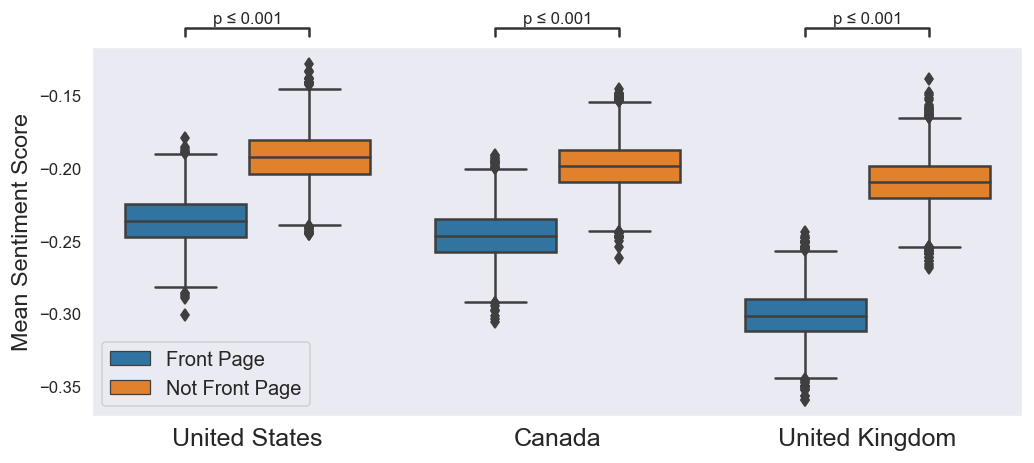

In [49]:
fig, ax = plt.subplots(1,1, dpi=120, figsize=(10,4))
ax = sns.boxplot(data=cc, y='boot_mean' ,x='country', ax=ax, hue='page')
annotator = Annotator(ax,pairs=pairs , data=cc, x='country', y='boot_mean', hue='page')

annotator.configure(
                    # test='t-test_ind', 
                    text_format='simple', 
                    loc='outside', 
                    # line_height=0.05, 
                    # show_test_name=False, 
                    # text_offset=5,
                    # line_offset=10
                    )

annotator.set_pvalues([0.0001, 0.0001, 0.0001])
annotator.annotate()

ax.tick_params(axis='x', which='major', labelsize=15)
plt.xlabel("");
plt.ylabel("Mean Sentiment Score", fontsize=14)
# plt.legend(loc="lower center", fontsize='large', bbox_to_anchor=(0.35,0.05))
plt.legend(fontsize='large')
# plt.savefig(f"{LATEX_FIGURE_PATH}/page_number_pvalues.png", dpi=200, bbox_inches="tight");

## Published per Day

In [50]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_prod['date'], y=df_prod['Articles Published per Day'], name="Number of Articles Published", line={'color':'black'}),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_prod['date'], y=df_prod['positive_rate'], name="Covid Positive Rate"),
    secondary_y=True, 
)
fig.update_yaxes(title_text="Number of Articles Published per Day", secondary_y=False)
fig.update_yaxes(title_text="Covid Positive Rate", secondary_y=True)
fig.update_layout(legend=dict(
    yanchor="top",
    y=1.09,
    xanchor="left",
    x=0,
    orientation="h",
    bgcolor='snow'
))

joe_wins = "2020-11-07"
moderna_pfizer = "2020-12-14"
delta_wave = "2021-06-17"
omicron_wave = "2021-11-01"

fig.add_annotation(
    x=joe_wins
    , y=660
    , text='Joe Biden Wins'
    , yanchor='auto'
    , xanchor='auto'
    , align='right'
    , font=dict(size=12, color="green", family="Sans Serif")
    ,)

fig.add_annotation(
    x=moderna_pfizer
    , y=800
    , text='Vaccine Approval'
    , yanchor='auto'
    , xanchor='auto'
    , font=dict(size=12, color="green", family="Sans Serif")
    ,)
fig.add_annotation(
    x=delta_wave
    , y=700
    , text='Delta Wave'
    , yanchor='bottom'
    , font=dict(size=12, color="black", family="Sans Serif")
    ,)

fig.add_annotation(
    x=omicron_wave
    , y=700
    , text='Omicron Wave'
    , yanchor='bottom'
    , font=dict(size=12, color="black", family="Sans Serif")
    ,)

# add vertical lines
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=joe_wins, x1=joe_wins,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                        ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=moderna_pfizer, x1=moderna_pfizer,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot",
                                  )
                    ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=delta_wave, x1=delta_wave,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                        ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=omicron_wave, x1=omicron_wave,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                       )
                  ])

# pio.write_image(fig, f"{LATEX_FIGURE_PATH}/articles_published_per_day.pdf", width=1000)
# fig

In [51]:
df_prod['diff_num_pub'] = df_prod['num_articles_published'].diff()
df_prod.corr('spearman', numeric_only=True)[['Articles Published per Day', 'num_articles_published', 'diff_num_pub']]

,Articles Published per Day,num_articles_published,diff_num_pub
prediction,-0.375497,-0.230064,-0.020534
article_classification,-0.364789,-0.228734,-0.020936
num_articles_published,0.824644,1.000000,0.283046
vader_prediction,0.378950,0.388849,0.006700
bert_prediction,0.043120,0.010979,-0.004617
vader_binary_prediction,0.415274,0.413946,0.028368
stringency_index,0.701900,0.611161,0.021011
positive_rate,0.693461,0.590157,0.048717
new_cases_smoothed,0.171266,0.136595,-0.005100
new_deaths_smoothed,0.269860,0.243478,-0.024235


**NOTE** It appears that ProQuest has a change in scraping around april where the majority of articles are front page articles. Not sure why this happens. I could supplement this story by just checking headlines and how often a headline mentions "Covid".

## National vs Local  Sentiment

In [52]:
eur_grouped[['Big_company', 'national']] = eur_grouped[['Big_company', 'national']].fillna(False)
big_company_mean = eur_grouped.groupby('Big_company')['prediction'].mean()
print(big_company_mean)

print("Difference in mean sentiment score between big companies and small companies")
print(big_company_mean.loc[True] - big_company_mean.loc[False])
print()

can_grouped[['Big_company', 'national']] = can_grouped[['Big_company', 'national']].fillna(False)
big_company_mean = can_grouped.groupby('Big_company')['prediction'].mean()
print(big_company_mean)
national_mean = can_grouped.groupby('national')['prediction'].mean()
print(national_mean)
print()
print(big_company_mean.loc[True] - big_company_mean.loc[False])


Big_company
False   -0.152998
True    -0.317671
Name: prediction, dtype: double[pyarrow]
Difference in mean sentiment score between big companies and small companies
-0.16467236851180317

Big_company
False   -0.164137
True    -0.247970
Name: prediction, dtype: double[pyarrow]
national
False   -0.187228
True    -0.235244
Name: prediction, dtype: double[pyarrow]

-0.08383282672228742


In [53]:
df_grouped[['Big_company', 'national']] = df_grouped[['Big_company', 'national']].fillna(False)
big_company_mean = df_grouped.groupby('Big_company')['prediction'].mean()
print(big_company_mean)
national_mean = df_grouped.groupby('national')['prediction'].mean()
print(national_mean)
print(big_company_mean.loc[True] - big_company_mean.loc[False])
print()
print(national_mean.loc[True] - national_mean.loc[False])

Big_company
False   -0.189840
True    -0.262023
Name: prediction, dtype: double[pyarrow]
national
False   -0.177977
True    -0.275269
Name: prediction, dtype: double[pyarrow]
-0.07218375625427928

-0.09729256514570817


In [54]:
us_national_news = df_grouped.pivot_table(index='date', columns='national', values='prediction', aggfunc='mean')
us_national_news = us_national_news.reset_index().rename(columns={False: 'Local', True:'National'})
smoother = LowessSmoother(smooth_fraction=0.02, iterations=2)
smoother.smooth((us_national_news['Local'], us_national_news['National']))
smoothed_L, smoothed_N = smoother.smooth_data
us_national_news['smoothed_local'] = smoothed_L
us_national_news['smoothed_national'] = smoothed_N

eur_national_news = eur_grouped.pivot_table(index='date', columns='Big_company', values='prediction', aggfunc='mean')
eur_national_news = eur_national_news.reset_index().rename(columns={False: 'Local', True:'National'})
smoother = LowessSmoother(smooth_fraction=0.02, iterations=2)
smoother.smooth((eur_national_news['Local'], eur_national_news['National']))
smoothed_L, smoothed_N = smoother.smooth_data
eur_national_news['smoothed_local'] = smoothed_L
eur_national_news['smoothed_national'] = smoothed_N

can_national_news = can_grouped.pivot_table(index='date', columns='Big_company', values='prediction', aggfunc='mean')
can_national_news = can_national_news.reset_index().rename(columns={False: 'Local', True:'National'})
smoother = LowessSmoother(smooth_fraction=0.02, iterations=2)
smoother.smooth((can_national_news['Local'], can_national_news['National']))
smoothed_L, smoothed_N = smoother.smooth_data
can_national_news['smoothed_local'] = smoothed_L
can_national_news['smoothed_national'] = smoothed_N

In [55]:
can_national_news['smoothed_local_diff'] = can_national_news['smoothed_local'].diff()
can_national_news['smoothed_national_diff'] = can_national_news['smoothed_national'].diff()

eur_national_news['smoothed_local_diff'] = eur_national_news['smoothed_local'].diff()
eur_national_news['smoothed_national_diff'] = eur_national_news['smoothed_national'].diff()

us_national_news['smoothed_local_diff'] = us_national_news['smoothed_local'].diff()
us_national_news['smoothed_national_diff'] = us_national_news['smoothed_national'].diff()

us_national_news['Covid-19 Positive Rate'] = df_prod['positive_rate_diff']
eur_national_news['Covid-19 Positive Rate'] = eur_prod['positive_rate_diff']
can_national_news['Covid-19 Positive Rate'] = can_prod['positive_rate_diff']

In [56]:
us_national_news.corr('spearman', numeric_only=True)

national,Local,National,smoothed_local,smoothed_national,smoothed_local_diff,smoothed_national_diff,Covid-19 Positive Rate
national,,,,,,,
Local,1.000000,0.653169,0.899961,0.753396,-0.019706,-0.061678,-0.231713
National,0.653169,1.000000,0.652278,0.805015,0.091023,0.004142,-0.231156
smoothed_local,0.899961,0.652278,1.000000,0.833189,0.013046,-0.062182,-0.260937
smoothed_national,0.753396,0.805015,0.833189,1.000000,0.156069,0.038770,-0.291699
smoothed_local_diff,-0.019706,0.091023,0.013046,0.156069,1.000000,0.405726,-0.405230
smoothed_national_diff,-0.061678,0.004142,-0.062182,0.038770,0.405726,1.000000,-0.238294
Covid-19 Positive Rate,-0.231713,-0.231156,-0.260937,-0.291699,-0.405230,-0.238294,1.000000


In [57]:
eur_national_news.corr('spearman', numeric_only=True)

Big_company,Local,National,smoothed_local,smoothed_national,smoothed_local_diff,smoothed_national_diff,Covid-19 Positive Rate
Big_company,,,,,,,
Local,1.000000,0.589102,0.728444,0.639492,-0.027080,0.014056,-0.154202
National,0.589102,1.000000,0.651573,0.766226,0.040428,0.055085,-0.185172
smoothed_local,0.728444,0.651573,1.000000,0.859287,0.032612,-0.010362,-0.244097
smoothed_national,0.639492,0.766226,0.859287,1.000000,0.052071,0.062615,-0.245264
smoothed_local_diff,-0.027080,0.040428,0.032612,0.052071,1.000000,0.517665,-0.244964
smoothed_national_diff,0.014056,0.055085,-0.010362,0.062615,0.517665,1.000000,-0.191042
Covid-19 Positive Rate,-0.154202,-0.185172,-0.244097,-0.245264,-0.244964,-0.191042,1.000000


In [58]:
can_prod['positive_rate'] = can_prod['positive_rate'].fillna(method='ffill')

/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3583376849.py:1: PerformanceWarning:

Falling back on a non-pyarrow code path which may decrease performance.



In [59]:
column_tuples = [("United States", "Average Sentiment"),
                 ("United States", "Correlation"),
                 ("Canada", "Average Sentiment"),
                 ("Canada", "Correlation"),
                 ("United Kingdom", "Average Sentiment"),
                 ("United Kingdom", "Correlation"),
                 ]

data = [
    [-0.17, -0.28, -0.16, -0.25, -0.15, -0.31],
    [-0.24, -0.41, -0.13, -0.13, -0.25, -0.19]
    
]

multiindex_columns = pd.MultiIndex.from_tuples(column_tuples)
style_df = pd.DataFrame(data, columns=multiindex_columns, index=['Regional', 'National'])
df_style = style_df.style.format(decimal='.', thousands=',', precision=2)
df_style
# # df_style.to_latex(f"{LATEX_TABLE_PATH}/local_national_table.tex",
# #                     caption="Sentiment Score by Page Number and Country",
# #                     label="table:local_national_table",
# #                     hrules=True,
# #                     column_format="l|cc|cc|cc",
# #                     # column_format="l|l@{\hskip 0.4in}l@{\hskip 0.4in}l@{\hskip 0.4in}ccc",
# #                     multicol_align='c|',
# #                     position_float="centering",
#                     # convert_css=True,
#                     )

In [60]:
can_national_news['Covid-19 Positive Rate'] = can_prod['positive_rate'].diff()

In [61]:
can_national_news.corr('spearman', numeric_only=True)

Big_company,Local,National,smoothed_local,smoothed_national,smoothed_local_diff,smoothed_national_diff,Covid-19 Positive Rate
Big_company,,,,,,,
Local,1.000000,0.570529,0.749110,0.585397,-0.005097,-0.072066,-0.162265
National,0.570529,1.000000,0.614428,0.792394,0.107620,0.024460,-0.181544
smoothed_local,0.749110,0.614428,1.000000,0.773340,0.028886,-0.094900,-0.190003
smoothed_national,0.585397,0.792394,0.773340,1.000000,0.151116,0.044489,-0.220998
smoothed_local_diff,-0.005097,0.107620,0.028886,0.151116,1.000000,0.599382,-0.124827
smoothed_national_diff,-0.072066,0.024460,-0.094900,0.044489,0.599382,1.000000,-0.139236
Covid-19 Positive Rate,-0.162265,-0.181544,-0.190003,-0.220998,-0.124827,-0.139236,1.000000


In [62]:
eur_prod['positive_rate'] = eur_prod['positive_rate'].fillna(method='ffill')

/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3501586345.py:1: PerformanceWarning:

Falling back on a non-pyarrow code path which may decrease performance.



In [63]:
can_prod['positive_rate'] = can_prod['positive_rate'].fillna(method='ffill')

/var/folders/z5/hcjfvqmn1pj4p04lhp8cxjsm0000gp/T/ipykernel_3291/3583376849.py:1: PerformanceWarning:

Falling back on a non-pyarrow code path which may decrease performance.



In [64]:
fig = make_subplots(rows=3, 
                    cols=1 
                    , shared_xaxes=True
                    , subplot_titles=['United States', 'Canada', 'Europe']
                    , vertical_spacing=0.05
                    , y_title='Sentiment Score'
                    ,specs=[[{"secondary_y": True}], 
                             [{"secondary_y": True}], 
                             [{"secondary_y": True}],],
                    )

fig.add_trace(go.Scatter(x=us_national_news['date'], y=us_national_news['smoothed_national'], name='National', line={'color':'#585fcc'}, opacity=0.9, showlegend=False),
              row=1, col=1)
fig.add_trace(go.Scatter(x=us_national_news['date'], y=us_national_news['smoothed_local'], name='Local', line={'color':'green'},showlegend=False), 
              row=1, col=1)
fig.add_trace(go.Scatter(x=us_national_news['date'], y=df_prod['positive_rate'], name='Covid-19 Positive Rate', line={'color':'red'},showlegend=False) 
              ,row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=can_national_news['date'], y=can_national_news['smoothed_national'], name='National', line={'color':'#585fcc'}, opacity=0.9, showlegend=False)
              , row=2, col=1)
fig.add_trace(go.Scatter(x=can_national_news['date'], y=can_national_news['smoothed_local'], name='Local', line={'color':'green'},showlegend=False), 
              row=2, col=1)
fig.add_trace(go.Scatter(x=can_national_news['date'], y=can_prod['positive_rate']**0.5, name='Covid-19 Positive Rate', line={'color':'red'},showlegend=False) 
              ,row=2, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=eur_national_news['date'], y=eur_national_news['smoothed_national'], name='National', line={'color':'#585fcc'}, opacity=0.9),
              row=3, col=1)
fig.add_trace(go.Scatter(x=eur_national_news['date'], y=eur_national_news['smoothed_local'], name='Regional', line={'color':'green'}),
              row=3, col=1)
fig.add_trace(go.Scatter(x=eur_national_news['date'], y=eur_prod['positive_rate'], name='Covid-19 Positive Rate', line={'color':'red'},showlegend=True) 
              ,row=3, col=1, secondary_y=True)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.02,
    orientation="h",
    bgcolor='snow',
    font=dict(size=13)
))
fig.update_yaxes(title_text="Covid Positive Rate", secondary_y=True, row=2, col=1)
fig.update_layout(height=900, width=1100,)
# fig.write_image(f"{LATEX_FIGURE_PATH}/national_news.pdf")
fig

## Political Affiliation Sentiment


Some problems right now is the low sample size for republicans. Also, when combining them under the new classification the differences aren't large anymore.

In [65]:
def get_publisher_df(dataframe):
    dataframe = dataframe.groupby('date').agg({'prediction': 'mean', 'page_num':'count'})
    smoother = LowessSmoother(smooth_fraction=0.07, iterations=4)
    smoother.smooth((dataframe['prediction'], dataframe['page_num']))
    dataframe['smoothed_prediction'] = smoother.smooth_data[0]
    dataframe['Articles Published per Day'] = smoother.smooth_data[1]
    return dataframe

nyt_df = df_grouped[df_grouped.publisher == "New York Times"]
wsj_df = df_grouped[df_grouped.publisher == "Wall Street Journal"]
wp_df = df_grouped[df_grouped.publisher == "Washington Post The"]
fox_df = df_grouped[df_grouped.publisher == "Fox News"]

nyt_df = get_publisher_df(nyt_df)
wsj_df = get_publisher_df(wsj_df)
wp_df = get_publisher_df(wp_df)
fox_df = get_publisher_df(fox_df)

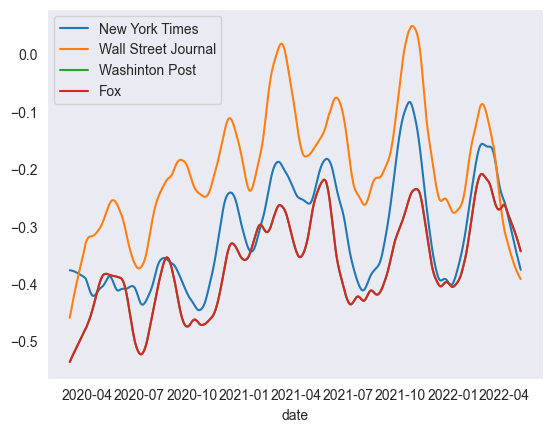

In [66]:
nyt_df['smoothed_prediction'].plot(label="New York Times")
wsj_df['smoothed_prediction'].plot(label='Wall Street Journal')
wp_df['smoothed_prediction'].plot(label='Washinton Post')
wp_df['smoothed_prediction'].plot(label='Fox')
plt.legend()

In [67]:
us_political_df_grouped = df_grouped.dropna(subset='political_ideology')

In [68]:
# sentiment_score = "article_classification"
sentiment_score = "prediction"
us_political_df_grouped = us_political_df_grouped.query("date < '2022-04-10'").copy()
date_series = us_political_df_grouped['date'].unique()
us_political_grouped_df = us_political_df_grouped.pivot_table(index='date', columns='political_ideology', values=sentiment_score, aggfunc='mean')

In [69]:
sentiment_score = "article_classification"
# sentiment_score = "prediction"
us_political_df_grouped_liberal = us_political_df_grouped.query("date < '2022-04-10'").copy()
us_political_df_grouped_liberal_df = us_political_df_grouped_liberal.pivot_table(index='date', columns='political_ideology', values=sentiment_score, aggfunc='mean')

In [70]:
smoother = LowessSmoother(smooth_fraction=0.03, iterations=2)
smoother.smooth((us_political_grouped_df['C'], us_political_grouped_df['R'], us_political_grouped_df['L']))
smoothed_c, smoothed_r, smoothed_l = smoother.smooth_data
us_political_df_grouped_liberal_df = pd.DataFrame({'date':date_series,'Moderate Prediction': smoothed_c, 'Republican Prediction': smoothed_r, 'Liberal Prediction': smoothed_l})

In [71]:
us_political_df_grouped_liberal_df.max()

date                     2022-04-09 00:00:00
Moderate Prediction                 0.158279
Republican Prediction               -0.10614
Liberal Prediction                  0.012774
dtype: object

In [72]:
smoother = LowessSmoother(smooth_fraction=0.03, iterations=2)
smoother.smooth((us_political_grouped_df['C'], us_political_grouped_df['R'], us_political_grouped_df['L']))
smoothed_c, smoothed_r, smoothed_l = smoother.smooth_data
us_political_avg_sentiment = pd.DataFrame({'date':date_series,'Moderate Prediction': smoothed_c, 'Republican Prediction': smoothed_r, 'Liberal Prediction': smoothed_l})

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_political_avg_sentiment['date'], y=us_political_avg_sentiment['Republican Prediction'], name='Right-Wing', line={'color':'#fc2626'}, opacity=0.8))
fig.add_trace(go.Scatter(x=us_political_avg_sentiment['date'], y=us_political_avg_sentiment['Liberal Prediction'], name='Left-Wing', line={'color':'#585fcc'}, opacity=0.8))
fig.add_trace(go.Scatter(x=us_political_avg_sentiment['date'], y=us_political_avg_sentiment['Moderate Prediction'], name='Centrist', line={'color':'#a18796'}))
fig.update_yaxes(title_text="Sentiment Score")

fig.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=0.03,
    orientation="v",
    bgcolor='snow',
    font=dict(size=11)
))

joe_wins = "2020-11-07"
moderna_pfizer = "2020-12-14"
delta_wave = "2021-06-17"
omicron_wave = "2021-11-01"
fig.add_annotation(
    x=joe_wins
    , y=-0.15
    , text='Joe Biden Wins'
    , yanchor='auto'
    , font=dict(size=12, color="green", family="Sans Serif")
    ,)

fig.add_annotation(
    x=moderna_pfizer
    , y=0
    , text='Vaccine Approval'
    , yanchor='auto'
    , font=dict(size=12, color="green", family="Sans Serif")
    ,)
fig.add_annotation(
    x=delta_wave
    , y=0.10
    , text='Delta Wave'
    , yanchor='top'
    , font=dict(size=12, color="black", family="Sans Serif")
    , xanchor="auto"
    # , arrowhead=1
    , ax= 30
    ,)

fig.add_annotation(
    x=omicron_wave
    , y=0
    , text='Omicron Wave'
    , yanchor='bottom'
    , font=dict(size=12, color="black", family="Sans Serif")
    ,)

# add vertical lines
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=joe_wins, x1=joe_wins,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                        ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=moderna_pfizer, x1=moderna_pfizer,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                    ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=delta_wave, x1=delta_wave,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                        ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=omicron_wave, x1=omicron_wave,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                       )
                  ])

# pio.write_image(fig, f"{LATEX_FIGURE_PATH}/political_sentiment_trend.pdf", width=1000)
print(f'Number of days more positive articles: {np.sum(us_political_avg_sentiment["Liberal Prediction"] >= 0.02)}')
print(f'Number of days more positive articles: {np.sum(us_political_avg_sentiment["Republican Prediction"] >= 0.02)}')
print(f'Number of days more positive articles: {np.sum(us_political_avg_sentiment["Moderate Prediction"] >= 0.02)}')
fig

Number of days more positive articles: 0
Number of days more positive articles: 0
Number of days more positive articles: 90


In [74]:
political_corr_table = us_political_avg_sentiment.rename(columns={'Republican Prediction':'Republican',
                                                                  'Liberal Prediction':'Liberal',
                                                                  'Moderate Prediction':'Moderate'})\
                                                .corr('spearman', numeric_only=True).round(3)
political_corr_table

,Moderate,Republican,Liberal
Moderate,1.000,0.550,0.898
Republican,0.550,1.000,0.444
Liberal,0.898,0.444,1.000


In [75]:
start_pandemic_diff = us_political_avg_sentiment.query("date < '06-15-2021'").mean()
later_pandemic_diff = us_political_avg_sentiment.query("date >= '06-15-2021'").mean()
# check_avg_diff.loc['Moderate Prediction'] - check_avg_diff.loc['Liberal Prediction']
print(start_pandemic_diff.loc['Moderate Prediction'] - start_pandemic_diff.loc['Liberal Prediction'])
print(later_pandemic_diff.loc['Moderate Prediction'] - later_pandemic_diff.loc['Liberal Prediction'])
check_avg_diff = us_political_avg_sentiment.mean(numeric_only=True)

0.11273146892638641
0.061452343015700656


In [76]:
check_avg_diff.loc['Moderate Prediction'] - check_avg_diff.loc['Liberal Prediction']
start_pandemic_diff.loc['Moderate Prediction'] - start_pandemic_diff.loc['Liberal Prediction']

0.11273146892638641

In [77]:
political_corr_table = us_political_avg_sentiment.rename(columns={'Republican Prediction':'Republican','Liberal Prediction':'Liberal','Moderate Prediction':'Moderate', }).corr('spearman', numeric_only=True).round(3)
check_avg_diff = us_political_avg_sentiment.mean(numeric_only=True)
print(check_avg_diff.loc['Liberal Prediction'] - check_avg_diff.loc['Republican Prediction'])
print(df_prod['smoothed_article_class'].mean() - regular_prod['smoothed_article_class'].mean())
print(us_political_grouped_df['L'].mean() - us_political_grouped_df['R'].mean())
print(df['prediction'].mean() - regular_df['prediction'].mean())
political_corr_table

0.013412618003484922
-0.24003298743453572
0.006782109234346412
-0.1738535651922299


,Moderate,Republican,Liberal
Moderate,1.000,0.550,0.898
Republican,0.550,1.000,0.444
Liberal,0.898,0.444,1.000


In [78]:
# print(us_political_avg_sentiment.merge(df_prod[['date', 'positive_rate_diff', 'new_cases_smoothed_diff']], on='date', how='left').corr('spearman', numeric_only=True))
us_political_avg_sentiment.merge(df_prod[['date', 'positive_rate_diff', 'new_cases_smoothed_diff']], on='date', how='left').corr('pearson', numeric_only=True)

,Moderate Prediction,Republican Prediction,Liberal Prediction,positive_rate_diff,new_cases_smoothed_diff
Moderate Prediction,1.000000,0.570205,0.924637,-0.268494,-0.218283
Republican Prediction,0.570205,1.000000,0.449500,-0.085027,-0.027061
Liberal Prediction,0.924637,0.449500,1.000000,-0.266258,-0.205979
positive_rate_diff,-0.268494,-0.085027,-0.266258,1.000000,0.501663
new_cases_smoothed_diff,-0.218283,-0.027061,-0.205979,0.501663,1.000000


In [79]:
us_political_avg_sentiment['positive_rate_diff'] = df_prod['positive_rate_diff']
us_political_avg_sentiment[['Moderate Prediction_diff','Republican Prediction_diff','Liberal Prediction_diff']] = us_political_avg_sentiment[['Moderate Prediction','Republican Prediction','Liberal Prediction']].diff()

<Axes: >

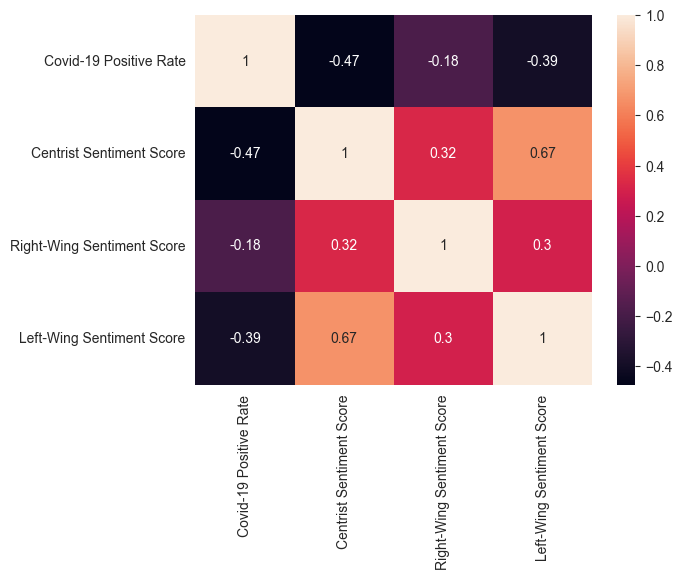

In [82]:
new_table_corr = us_political_avg_sentiment.drop(columns=['Moderate Prediction', 'Republican Prediction', 'Liberal Prediction'])
new_table_corr = new_table_corr.rename(columns={'Moderate Prediction_diff':'Centrist Sentiment Score', 
                                                'Republican Prediction_diff':'Right-Wing Sentiment Score', 
                                                'Liberal Prediction_diff':'Left-Wing Sentiment Score',
                                                'positive_rate_diff': 'Covid-19 Positive Rate'}, errors='ignore')
new_table_corr = new_table_corr.corr('spearman', numeric_only=True).round(3)
sns.heatmap(new_table_corr, annot=True)
# plt.savefig(f"{LATEX_FIGURE_PATH}/political_sentiment_correlation.pdf", dpi=250, bbox_inches="tight")

In [83]:
us_political_avg_sentiment.merge(df_prod[['date', 'positive_rate_diff', 'new_cases_smoothed_diff', 'weekly_hosp_admissions_diff']], on='date', how='left').corr('spearman', numeric_only=True)

,Moderate Prediction,Republican Prediction,Liberal Prediction,positive_rate_diff_x,Moderate Prediction_diff,Republican Prediction_diff,Liberal Prediction_diff,positive_rate_diff_y,new_cases_smoothed_diff,weekly_hosp_admissions_diff
Moderate Prediction,1.000000,0.549835,0.898117,-0.298933,0.043210,0.000069,-0.074304,-0.298933,-0.517875,-0.574977
Republican Prediction,0.549835,1.000000,0.444274,-0.178057,0.049221,0.056005,-0.053245,-0.178057,-0.261419,-0.278005
Liberal Prediction,0.898117,0.444274,1.000000,-0.335136,0.171957,0.046889,0.020951,-0.335136,-0.505001,-0.588402
positive_rate_diff_x,-0.298933,-0.178057,-0.335136,1.000000,-0.472928,-0.183199,-0.393498,1.000000,0.547407,0.615820
Moderate Prediction_diff,0.043210,0.049221,0.171957,-0.472928,1.000000,0.323741,0.672049,-0.472928,-0.217930,-0.272944
Republican Prediction_diff,0.000069,0.056005,0.046889,-0.183199,0.323741,1.000000,0.295562,-0.183199,0.010485,0.010399
Liberal Prediction_diff,-0.074304,-0.053245,0.020951,-0.393498,0.672049,0.295562,1.000000,-0.393498,-0.179806,-0.285660
positive_rate_diff_y,-0.298933,-0.178057,-0.335136,1.000000,-0.472928,-0.183199,-0.393498,1.000000,0.547407,0.615820
new_cases_smoothed_diff,-0.517875,-0.261419,-0.505001,0.547407,-0.217930,0.010485,-0.179806,0.547407,1.000000,0.705012
weekly_hosp_admissions_diff,-0.574977,-0.278005,-0.588402,0.615820,-0.272944,0.010399,-0.285660,0.615820,0.705012,1.000000


In [86]:
us_political_avg_sentiment.mean(numeric_only=True)

Moderate Prediction          -0.163435
Republican Prediction        -0.269666
Liberal Prediction           -0.256254
positive_rate_diff           -0.000094
Moderate Prediction_diff     -0.000202
Republican Prediction_diff   -0.000002
Liberal Prediction_diff       0.000187
dtype: float64

In [87]:
us_political_avg_sentiment.corr('spearman', numeric_only=True)

,Moderate Prediction,Republican Prediction,Liberal Prediction,positive_rate_diff,Moderate Prediction_diff,Republican Prediction_diff,Liberal Prediction_diff
Moderate Prediction,1.000000,0.549835,0.898117,-0.298933,0.043210,0.000069,-0.074304
Republican Prediction,0.549835,1.000000,0.444274,-0.178057,0.049221,0.056005,-0.053245
Liberal Prediction,0.898117,0.444274,1.000000,-0.335136,0.171957,0.046889,0.020951
positive_rate_diff,-0.298933,-0.178057,-0.335136,1.000000,-0.472928,-0.183199,-0.393498
Moderate Prediction_diff,0.043210,0.049221,0.171957,-0.472928,1.000000,0.323741,0.672049
Republican Prediction_diff,0.000069,0.056005,0.046889,-0.183199,0.323741,1.000000,0.295562
Liberal Prediction_diff,-0.074304,-0.053245,0.020951,-0.393498,0.672049,0.295562,1.000000


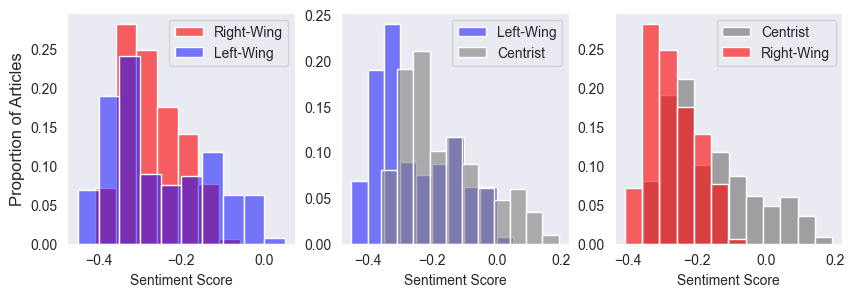

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

bins=8
sns.histplot(data=us_political_avg_sentiment, x='Republican Prediction', stat='proportion', label='Right-Wing', color='red',  alpha=0.6, ax=axs[0], bins=bins, binwidth=0.05)
sns.histplot(data=us_political_avg_sentiment, x='Liberal Prediction', stat='proportion', label='Left-Wing', color='blue',  alpha=0.5, ax=axs[0], bins=bins, binwidth=0.05)

sns.histplot(data=us_political_avg_sentiment, x='Liberal Prediction', stat='proportion', label='Left-Wing', color='blue', alpha=0.5, ax=axs[1], bins=bins, binwidth=0.05)
sns.histplot(data=us_political_avg_sentiment, x='Moderate Prediction', stat='proportion', label='Centrist', color='grey', alpha=0.6, ax=axs[1], bins=bins, binwidth=0.05)

sns.histplot(data=us_political_avg_sentiment, x='Moderate Prediction', stat='proportion', label='Centrist', color='grey', alpha=0.7, ax=axs[2], bins=bins, binwidth=0.05)
sns.histplot(data=us_political_avg_sentiment, x='Republican Prediction', stat='proportion', label='Right-Wing', alpha=0.6, color='red', ax=axs[2], bins=bins, binwidth=0.05)

axs[0].legend();
axs[0].set_xlabel('Sentiment Score');
axs[1].set_xlabel('Sentiment Score');
axs[2].set_xlabel('Sentiment Score');
axs[0].set_ylabel('Proportion of Articles', fontsize=12);
axs[1].set_ylabel('');
axs[2].set_ylabel('');
axs[1].legend();
axs[2].legend();
# plt.savefig(f'{LATEX_FIGURE_PATH}/liberal_vs_rep_hist.pdf', dpi=250, bbox_inches="tight")

In [825]:
# sns.histplot(data=us_political_avg_sentiment, x='Republican Prediction', stat='proportion', label='Right-Wing', color='red',  alpha=0.5, bins=8, kde=True)
# sns.histplot(data=us_political_avg_sentiment, x='Liberal Prediction', stat='proportion', label='Left-Wing', color='blue', alpha=0.3, kde=True)
# sns.histplot(data=us_political_avg_sentiment, x='Moderate Prediction', stat='proportion', label='Centrist', alpha=0.7, kde=True)
# plt.legend();
# plt.xlabel('Sentiment Score')
# plt.savefig(f'{LATEX_FIGURE_PATH}/liberal_vs_rep_hist.pdf', dpi=125)

In [40]:
# us_political_avg_sentiment.to_parquet('/Users/gabriel/Desktop/portfolio-dashboard/assets/us_political_sentiment.parquet')

### Check the number of articles published for each political group

In [89]:
article_grouped = df.groupby('article_id', as_index=False).agg({'date':'first', 'political_ideology':'first'})
article_grouped = article_grouped[article_grouped['political_ideology'].notna()]
num_published_political = article_grouped.pivot_table(index='date', columns='political_ideology', values='article_id', aggfunc='count')

num_published_political = num_published_political.reset_index().merge(health_data_df.loc['United States'], on='date', how='inner')

smoother = LowessSmoother(smooth_fraction=0.015)
smoother.smooth((num_published_political['C'], num_published_political['L'], num_published_political['R']))
num_published_political[["smoothed_C", "smoothed_L", "smoothed_R"]] = smoother.smooth_data.T

In [91]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=num_published_political['date'], y=num_published_political['smoothed_C'], name='Moderate', line={'color':'#585fcc'}, opacity=0.9))
fig.add_trace(go.Scatter(x=num_published_political['date'], y=num_published_political['smoothed_L'], name='Liberal',))
fig.add_trace(go.Scatter(x=num_published_political['date'], y=num_published_political['positive_rate'], name='positive_rate', opacity=0.4), secondary_y=True, )
# fig.add_trace(go.Scatter(x=num_published_political['date'], y=num_published_political['new_cases_smoothed'], name='new_cases_smoothed', opacity=0.4), secondary_y=True, )

Now we will create date intervals after big events and check the max (or min?) number of published articles within that date range. This is a standardized way that isn't obviously biased and reproducible.

In [92]:
def percent_change(new, old):
    return round((new - old) / old, 4)


def num_published_percent_change(first_event_date_range, after_event_date_range):
    first_event_df = num_published_political[num_published_political['date'].isin(first_event_date_range)].copy()
    second_event_df = num_published_political[num_published_political['date'].isin(after_event_date_range)].copy()
    
    max_repub = first_event_df['R'].max()
    max_mod = first_event_df['C'].max()
    max_lib = first_event_df['L'].max()
    
    min_repub = second_event_df['R'].max()
    min_mod = second_event_df['C'].max()
    min_lib = second_event_df['L'].max()
    
    print(f"Republican: {percent_change(min_repub, max_repub)}")
    # print(f"Moderate: {percent_change(min_mod, max_mod)}")
    print(f"Liberal: {percent_change(min_lib, max_lib)}", '\n')

first_wave_peak = pd.date_range(start="2020-04-01", end='2020-04-12')
first_wave_decline = pd.date_range(start="2020-06-01", end='2020-06-05')

first_wave_peak = pd.date_range(start="2020-07-10", end='2020-07-15')
first_wave_decline = pd.date_range(start="2020-09-25", end='2020-09-29')

second_wave_before_increase = pd.date_range(start="2020-09-11", end='2020-09-22')
second_wave_peak = pd.date_range(start="2020-12-15", end='2020-12-31')

before_summer_peak = pd.date_range(start="2020-12-10", end='2021-01-04')
end_summer = pd.date_range(start="2020-06-10", end='2020-06-15')

delta_wave_increase = pd.date_range(start="2021-07-30", end='2021-08-03')
delta_wave_end = pd.date_range(start="2021-10-20", end='2021-10-28')

omicron_wave_increase = pd.date_range(start="2021-12-20", end='2022-01-12')
omicron_wave_end = pd.date_range(start="2022-02-20", end='2022-03-23')

num_published_percent_change(first_wave_peak, first_wave_decline)
num_published_percent_change(second_wave_before_increase, second_wave_peak)
num_published_percent_change(before_summer_peak, end_summer) 
num_published_percent_change(delta_wave_increase, delta_wave_end) 
num_published_percent_change(omicron_wave_increase, omicron_wave_end)
 

Republican: -0.4516
Liberal: -0.3557 

Republican: 0.3043
Liberal: 0.5929 

Republican: -0.3125
Liberal: -0.3795 

Republican: -0.3721
Liberal: -0.4058 

Republican: 1.0976
Liberal: -0.6582 



## Sentiment Score Graphs

In [93]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_prod['date'], y=df_prod['smoothed_article_class'], name="Covid News Sentiment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_prod['date'], y=df_prod['positive_rate'], name="Covid Positive Rate", opacity=0.7),
    secondary_y=True, 
)

fig.add_trace(
    go.Scatter(x=regular_prod['date'], y=regular_prod['smoothed_article_class'], name="Regular News Sentiment"),
    secondary_y=False, 
)

fig.add_trace(
go.Scatter(
        name='Upper Bound',
        x=df_prod['date'], 
        y=df_prod['upper_bound_classification'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.15)',
        showlegend=False
    ),
)

fig.add_trace(
go.Scatter(
        name='Lower Bound',
        x=df_prod['date'], 
        y=df_prod['lower_bound_classification'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.15)',
        fill='tonexty',
        showlegend=False
    ),
secondary_y=False,
)

fig.update_yaxes(title_text="Average Sentiment", secondary_y=False)
fig.update_yaxes(title_text="Covid Positive Rate", secondary_y=True)
fig.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=0.005,
    orientation="v",
    bgcolor='snow',
    font=dict(size=8)
))
# pio.write_image(fig, f"{LATEX_FIGURE_PATH}/main_sentiment_trend.pdf", width=1000, format='pdf')
fig

## Op-ed Articles

To test for this we can use a few methods. The main method will be sampling from the original dataframe and then computing the slope estimates during the important time periods. If the low sample size is robust enough to reproduce the slopes from the full dataset, then this indicates that the low sample size op-ed dataset is reliable enough to make slope estimates.

In [94]:
can_oped = df_can.query('is_oped == True')
can_non_oped = df_can.query('is_oped != True')
can_oped_prod = create_sentiment_per_day_df(can_oped, health_data_df.loc['Canada'])
can_non_oped_prod = create_sentiment_per_day_df(can_non_oped, health_data_df.loc['Canada'])
print('CANADA OPED CORRELATIONS')
print(can_oped_prod.iloc[:, :-4].corr('spearman', numeric_only=True)[['smoothed_article_class', 'smoothed_prediction']])
print('\n')
print('CANADA NON-OPED CORRELATIONS')
print(can_non_oped_prod.iloc[:, :-4].corr('spearman', numeric_only=True)[['smoothed_article_class', 'smoothed_prediction']])

CANADA OPED CORRELATIONS
                                smoothed_article_class  smoothed_prediction
prediction                                    0.430374             0.477697
article_classification                        0.436143             0.375544
num_articles_published                        0.060784             0.014349
stringency_index                              0.161693             0.105936
positive_rate                                -0.449930            -0.473136
new_cases_smoothed                           -0.492923            -0.571649
new_deaths_smoothed                          -0.222504            -0.265131
weekly_hosp_admissions                             NaN                  NaN
new_vaccinations_smoothed                     0.099600             0.140108
new_people_vaccinated_smoothed                0.100149             0.091268
new_cases                                    -0.471784            -0.554341
positive_rate_diff                           -0.050007         

In [95]:
print(can_non_oped_prod['smoothed_article_class'].mean())
print(can_oped_prod['smoothed_article_class'].mean())

-0.2496355762479681
-0.5468731039511919


In [96]:
eur_oped = df_eur.query('is_oped == True')
eur_non_oped = df_eur.query('is_oped != True')
eur_oped_prod = create_sentiment_per_day_df(eur_oped, health_data_df.loc['United Kingdom'])
eur_non_oped_prod = create_sentiment_per_day_df(eur_non_oped, health_data_df.loc['United Kingdom'])
print('UNITED KINGDOM OPED CORRELATIONS')
print(eur_oped_prod.iloc[:, :-4].corr('spearman', numeric_only=True)[['smoothed_article_class', 'smoothed_prediction']])
print('\n')
print('UNITED KINGDOM NON-OPED CORRELATIONS')
print(eur_non_oped_prod.iloc[:, :-4].corr('spearman', numeric_only=True)[['smoothed_article_class', 'smoothed_prediction']])


UNITED KINGDOM OPED CORRELATIONS
                                smoothed_article_class  smoothed_prediction
prediction                                    0.362057             0.455068
article_classification                        0.417602             0.324124
num_articles_published                        0.106564            -0.097191
stringency_index                              0.247930             0.070626
positive_rate                                -0.035493            -0.108246
new_cases_smoothed                           -0.047611             0.018165
new_deaths_smoothed                           0.243897             0.099099
weekly_hosp_admissions                        0.092523             0.024683
new_vaccinations_smoothed                     0.131177            -0.038827
new_people_vaccinated_smoothed                0.293938             0.159893
new_cases                                    -0.037129             0.013591
positive_rate_diff                           -0.138988 

In [97]:
print(eur_non_oped_prod['smoothed_article_class'].mean())
print(eur_oped_prod['smoothed_article_class'].mean())

-0.2929878395069978
-0.6468563836165603


In [98]:
df_oped_combined = df.query("date <= '2022-04-20' and date >= '2020-04-30' ")
# df_oped_combined = df.query("date <= '2022-01-15' and date >= '2020-04-30' ")
df_oped = df_oped_combined.query("is_oped == True").copy()

In [99]:
df_oped = get_article_grouped_df(df_oped)
df_non_oped = df_oped_combined.query("is_oped == False").copy()
df_non_oped = get_article_grouped_df(df_non_oped)

df_oped_prod = create_sentiment_per_day_df(df_oped, health_data_df.loc['United States'])
df_non_oped_prod = create_sentiment_per_day_df(df_non_oped, health_data_df.loc['United States'])

In [100]:
cc = df_oped_prod.query("date < '2021-01-01'")
dd = df_non_oped_prod.query("date < '2021-01-01'")

cc = df_oped_prod.query("date > '2021-02-20'")
dd = df_non_oped_prod.query("date > '2021-02-20'")

In [101]:
def classify_article_class(article_mean_sentiment, larger_cutoff=0.1):
    if article_mean_sentiment > larger_cutoff:
        return 1
    elif article_mean_sentiment < -larger_cutoff:
        return -1
    else:
        return 0

In [102]:
df_oped_prod = df_oped.groupby(["date","article_id"], as_index=False).agg({'prediction':'mean'})
df_oped_prod['article_classification'] = df_oped_prod['prediction'].apply(lambda x: classify_article_class(x))
df_oped_prod = df_oped_prod.groupby('date', as_index=False).mean()
smoother = LowessSmoother(smooth_fraction=0.04, iterations=2)
smoother.smooth((df_oped_prod['article_classification'], df_oped_prod['prediction']))
lower_bound_prediction, upper_bound_prediction = smoother.get_intervals('sigma_interval', n_sigma=2)
df_oped_prod['double_smoothed'] = smoother.smooth_data[0]
df_oped_prod['smoothed_prediction'] = smoother.smooth_data[1]
df_oped_prod['double_smoothed_upper'] = upper_bound_prediction[0]
df_oped_prod['double_smoothed_lower'] = lower_bound_prediction[0]

In [104]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_prod['date'], y=df_prod['positive_rate'], name="Covid Positive Rate", line={'color':'red'}, opacity=0.35), secondary_y=True, )
fig.add_trace(go.Scatter(x=df_non_oped_prod['date'], y=df_non_oped_prod['smoothed_prediction'], name="Non-Oped Sentiment", line={'color':'blue'}, opacity=0.5))
fig.add_trace(go.Scatter(x=df_oped_prod['date'], y=df_oped_prod['smoothed_prediction'], name="Oped Sentiment", line={'color':'#877e80'}))

fig.update_layout(legend=dict(
    yanchor="top",
    y=1,
    xanchor="left",
    x=0.005,
    orientation="v",
    bgcolor='snow',
    font=dict(size=8)
))

fig.update_yaxes(title_text="Sentiment Score", secondary_y=False)
fig.update_yaxes(title_text="Covid Positive Rate", secondary_y=True)

joe_wins = "2020-11-07"
moderna_pfizer = "2020-12-14"
delta_wave = "2021-06-17"
omicron_wave = "2021-11-01"

fig.add_annotation(
    x=joe_wins
    , y=-0.15
    , text='Joe Biden Wins'
    , yanchor='bottom'
    , font=dict(size=12, color="green", family="Sans Serif")
    ,)

fig.add_annotation(
    x=moderna_pfizer
    , y=0
    , text='Vaccine Approval'
    , yanchor='bottom'
    , font=dict(size=12, color="green", family="Sans Serif")
    ,)
fig.add_annotation(
    x=delta_wave
    , y=0.05
    , text='Delta Wave'
    , yanchor='top'
    , font=dict(size=12, color="black", family="Sans Serif")
    , xanchor="auto"
    # , arrowhead=1
    , ax= 30
    ,)

fig.add_annotation(
    x=omicron_wave
    , y=0
    , text='Omicron Wave'
    , yanchor='bottom'
    , font=dict(size=12, color="black", family="Sans Serif")
    ,)

# add vertical lines
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=joe_wins, x1=joe_wins,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                        ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=moderna_pfizer, x1=moderna_pfizer,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                    ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=delta_wave, x1=delta_wave,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                        ),
                  dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=omicron_wave, x1=omicron_wave,
                        line=dict(color="MediumPurple",
                                  width=1.2,
                                  dash="dot")
                       )
                  ])
# pio.write_image(fig, f"{LATEX_FIGURE_PATH}/oped_sentiment_trend.pdf", width=1000)
fig